# TODO, NOTATKI



*   Wprowadzmy najpierw oba modele (Lorenz, SEIR) i zdefiniujmy ich metody tak zeby potem przy SA i 4dvar juz mozna sie bylo skupic na tych metodach
* Uzywajmy w SA i 4dvar metod modeli (lorenz_step, seir_step) zdefiniowanych tu na gorze



In [8]:
#DELETE THIS LATER
#!pip install adao
#!pip install SALib

     |████████████████████████████████| 174kB 7.1MB/s 
  Created wheel for adao: filename=adao-9.6.0.1-cp36-none-any.whl size=265870 sha256=e41d9c535e106311fdcbbd9db57da3f8be0c86867147bff174b3c06f49846c06
  Stored in directory: /root/.cache/pip/wheels/62/20/09/e20dd3ca7c1b80f4a614371b9b3fd41e54194c0c5f245c8c83
Successfully built adao
     |████████████████████████████████| 860kB 8.6MB/s 
  Created wheel for SALib: filename=SALib-1.3.12-py2.py3-none-any.whl size=729049 sha256=af56487a1d75eecd7626203ecaf39f81b319de5794968c5da8005017befa89fb
  Stored in directory: /root/.cache/pip/wheels/04/5c/9f/09d58ab84d5a7ef7d2e5fedc5cd2f46a64a77c99035571aa0c
Successfully built SALib


# Introduction to Lorenz and SEIR models



### Lorenz

![Lorenz equations](images/lorenz.png)

source: https://en.wikipedia.org/wiki/Lorenz_system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

Method that computes one timestep of Lorenz model:

In [2]:
def lorenz_step(state, _, rho, sigma, beta):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

Let's draw the model's trajectory for the basic parameters:

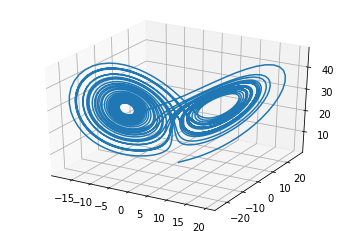

In [3]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

state0 = [1,1,1]

t = np.arange(0.0, 40.0, 0.01)

states = odeint(lorenz_step, state0, t, args=(rho,sigma,beta))

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

### SEIR

![SEIR epidemic model](images/seir.png)

There are five groups:
* S - group of humans **susceptible** to be exposed to the virus. Before an epidemic starts, all population members belong to this group.
* E - group of people that were **exposed** to the virus. In this stage they already started to develop the illness, but they don't show symptoms nor infect others yet.
* I - group of **infectious** individuals, who can pass the virus to susceptible members.
* R - people that have already **recovered** from the infection.
* D - an additional group of individuals that are **dead** as a result of the infection

---

There are four parameters:
* alfa - the case fatality rate - fraction of Infected group that dies each day. [0.001, 0.01]
* beta - probability of disease transmission times the number of contacts per day. [0, 7]
* epsilon - rate of progression from Exposed to Infectious (so 1/eps is the incubation period). [0.05, 0.5] (from 2 to 20 days)
* gamma - rate of progression from Infectious to Recovered (so 1/gamma is the length of the infectious period) [0.05, 5] (from 2 to 20 days)


---

These are the equations which represent the group size in the next time step:

S = S - S \* beta \* I / N  
E = E + S \* beta \* I / N - eps \* E  
I = I + eps \* E - (alfa + gamma) \* I  
R = R + gamma \* I  
D = alfa \* I  


In [4]:
def seir_step(state):
    state = list(np.ravel(state))
    state = list(map(lambda x : max(x, 0), state))
    S_old, E_old, I_old, R_old, D_old, alfa, beta, eps, gamma = state

    N = S_old + E_old + I_old + R_old
    D = D_old + alfa * I_old
    S = S_old - S_old * beta * I_old / N
    E = E_old + S_old * beta * I_old / N - eps * E_old
    I = I_old + eps * E_old - (alfa + gamma) * I_old
    R = R_old + gamma * I_old

    results = [S, E, I, R, D, alfa, beta, eps, gamma]
    return np.array(results).reshape(-1, 1)

Let's simulate a sample epidemic

**TASK 1** Choose some values from the reasonable bounds introduced earlier and observe the effect on the plots



Susceptible, exposed, infectious, recovered and dead individuals


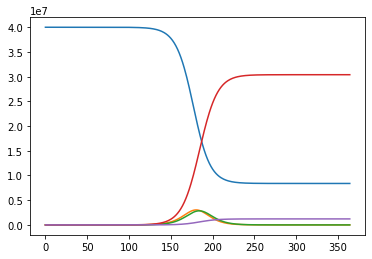

In [52]:
# TODO: insert values for alfa, beta, eps, gamma
params = [ ??? ]
seird = [40000000, 1, 0, 0, 0]
state = np.array(seird + params).reshape(-1, 1)

days = 365

states = np.empty((days,5))
for i in range(days):
    states[i]  = state[:5][:,0]
    state = seir_step(state)

plt.plot( range(days),states[:,0])
plt.plot( range(days),states[:,1])
plt.plot( range(days),states[:,2])
plt.plot( range(days),states[:,3])
plt.plot( range(days),states[:,4])
print('Susceptible, exposed, infectious, recovered and dead individuals')

Exposed, infectious and dead individuals


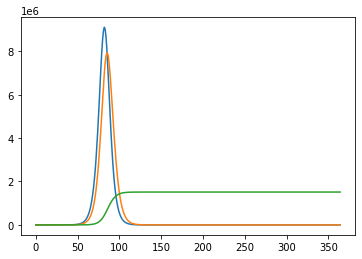

In [51]:
plt.plot( range(days),states[:,1])
plt.plot( range(days),states[:,2])
plt.plot( range(days),states[:,4])
print('Exposed, infectious and dead individuals')

# Sensitivity analysis

In order to check which parameters of the model have the biggest influence on the output, we can perform a Sensitivity Analysis. SALib is a Python library that implements it. It does two things:


1.   Generates a set of inputs to be fed to the model
2.   Analyses outputs returned by the model for this set of inputs


In [28]:
from SALib.sample import saltelli
from SALib.analyze import sobol

### Sensitivity analysis - Lorenz 63 model

We will perform SA on Lorenz 63 model. First, we need to define the parameters of the model and generate a set of input parameters.

In [46]:
problem = {
    'num_vars': 3,
    'names': ['rho', 'sigma', 'beta'],
    'bounds': [[14.0,42.0],
               [3.0, 20.0],
               [7.0/3.0, 9.0/3.0]]
}

#Let's generate 20 values for each parameter:
input = saltelli.sample(problem, 20)

print(input.shape)
print(input[:5])

(160, 3)
[[20.15234375  4.64355469  2.67903646]
 [32.94921875  4.64355469  2.67903646]
 [20.15234375  7.76464844  2.67903646]
 [20.15234375  4.64355469  2.93815104]
 [20.15234375  7.76464844  2.93815104]]


Now, we need to define our model and generate an output value for each input (each set of parameters)

Lorenz model has a 3-dimensional state (x,y,z) for each timestep. However, SA can only analyse a single output for a given input.

In order to deal with that, we will analyse the sensitivity in the 3 dimensions separately. We will analyse the standard deviation of values in each dimension.

In [40]:
def generate_outputs_lorenz(parameter_combinations):
    # We need an output array with a row for each generated input and 3 colums for 3 output variables (x, y, z)
    output = np.empty( shape=(parameter_combinations.shape[0],3) )
    # Define timesteps for Lorenz 63 integration
    t = np.arange(0.0, 40.0, 0.01)

    for i, params in enumerate(parameter_combinations):
        initial_state = [1,1,1]
        rho, sigma, beta = params[0], params[1], params[2]

        # Get states in each timestep:
        states = odeint(lorenz_step, initial_state, t, args=(rho, sigma, beta))

        # We take the standard deviation in each dimension as the output.
        output[i] = np.std(states, axis=0)
    return output

output = generate_outputs_lorenz(input)

Finally, we can analyse the sensitivity. We analyse it in respect to each output dimension separately

In [41]:
Si_X = sobol.analyze(problem, output[:,0], print_to_console=False)['S1']
Si_Y = sobol.analyze(problem, output[:,1], print_to_console=False)['S1']
Si_Z = sobol.analyze(problem, output[:,2], print_to_console=False)['S1']

print('           ', list(map(lambda name: name + ' '*(5-len(name)),    problem['names'])))
print('X analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si_X)))
print('Y analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si_Y)))
print('Z analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si_Z)))

            ['rho  ', 'sigma', 'beta ']
X analysis: ['1.046', '0.181', '0.105']
Y analysis: ['0.991', '0.166', '0.059']
Z analysis: ['0.969', '0.065', '0.045']


The higher the value, the more the parameter affects the behaviour of the model.
The rho parameter influences all dimensions of model significantly.

### Sensitivity analysis - SEIR model

Now we will perform a similar SA on the SEIR model

**TASK 2** Just like in the Lorenz example, define the number of variables, their names and the bounds. Use the bounds provided in the definition of the model

In [47]:
problem_seir = {
    'num_vars': ??? ,
    'names': ??? ,
    'bounds': ???
}

input = saltelli.sample(problem_seir, 100)

print(input.shape)
print(input[:5])

(1000, 4)
[[2.97753906e-03 6.76757812e-01 2.83349609e-01 3.54541016e-01]
 [3.52246094e-03 6.76757812e-01 2.83349609e-01 3.54541016e-01]
 [2.97753906e-03 6.35058594e+00 2.83349609e-01 3.54541016e-01]
 [2.97753906e-03 6.76757812e-01 7.06542969e-02 3.54541016e-01]
 [2.97753906e-03 6.76757812e-01 2.83349609e-01 4.54736328e-01]]


In [14]:
def generate_outputs_seir(parameter_combinations):
    # We need an output array with a row for each generated input
    output_final = np.empty( shape=(parameter_combinations.shape[0]) )
    output_max = np.empty( shape=(parameter_combinations.shape[0]) )

    for i, params in enumerate(parameter_combinations):
        initial_state = np.array([39900000, 60000, 10000, 80000, 2300])
        state = np.concatenate((initial_state, params))

        max_infected = 0
        for step in range(200):
            state = seir_step(state)
            if state[:][2] > max_infected:
                max_infected = state[:][2]
        output_final[i] = state[:][4]
        output_max[i] = max_infected
    return output_final, output_max

output_final, output_max = generate_outputs_seir(input)

In [20]:
print('                      ', list(map(lambda name: name + ' '*(5-len(name)),    problem_seir['names'])))
Si = sobol.analyze(problem_seir, output_final, print_to_console=False)['S1']
print('Final deaths analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si)))
Si = sobol.analyze(problem_seir, output_max, print_to_console=False)['S1']
print('Max infected analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si)))

                       ['alfa ', 'beta ', 'eps  ', 'gamma']
Final deaths analysis: ['0.219', '-0.002', '-0.004', '0.654']
Max infected analysis: ['0.001', '0.197', '0.334', '0.534']


# Data assimilation with 4DVar

### 4d var with Lorenz 63 model

[Dokumentacja](https://docs.salome-platform.org/latest/gui/ADAO/en/ref_algorithm_4DVAR.html)

In [ ]:
from data_assimilation import assimilate

In [ ]:
# fixme uzupełnic
xb = [1., 1., 1.]
error_vector = [10., 10., 10.]

### SEIR epidemic model

In [ ]:
def observation_operator(state):
    D = state.reshape((-1, 9))[:, 4]
    return D

In [ ]:
params = [8.96545184e-04, 5.43525126e-01, 8.58683367e-01, 4.33096921e-01]
seird = [100000, 100, 0, 0, 0]
state = np.array(seird + params).reshape(-1, 1)

In [ ]:
from data_assimilation import prepare_obs
yobs = prepare_obs(state, observation_operator, seir_step)

In [ ]:
error_vector = [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.5, 0.5, 0.5]
assimilate(seird + [0.01, 0.1, 0.1, 0.1], yobs, observation_operator, seir_step, error_vector)

Calibration of 9 coefficients in a 1D quadratic function on 100 measures
---------------------------------------------------------------------
Calibration resulting coefficients.: [ 1.00000000e+05  1.00000052e+02 -3.07929502e-05 -9.52867760e-09
 -5.14066307e-05  1.51462998e-02  6.24505216e-02  1.51464169e-02
 -1.02953781e-04]


### Assimilation of actual data

In [ ]:
from data_assimilation import load_data
yobs = load_data(size = 100, country = 'POL')

In [ ]:
assimilate(seird + [0.01, 0.1, 0.1, 0.1], yobs, observation_operator, evolution_function, error_vector, verbose=True)

Streaming output truncated to the last 5000 lines.
  Intermediate CostFunctionJb at the current iteration: 5.245818839382296
  Intermediate CostFunctionJo at the current iteration: 1689835256.3897326
  Intermediate CostFunctionJ at the current iteration: 1689835261.6355515
  Intermediate IndexOfOptimum at the current iteration: 131
  Intermediate CurrentOptimum at the current iteration: [ 1.00000000e+05  1.00029776e+02  2.33146554e-02 -2.18768193e-07
  1.60612151e-03  9.71014396e-01  6.16625879e-01  1.70811642e+00
 -1.77205211e-01]
  Intermediate CostFunctionJAtCurrentOptimum at the current iteration: 1689835261.6355515
  Intermediate CostFunctionJbAtCurrentOptimum at the current iteration: 5.245818839382296
  Intermediate CostFunctionJoAtCurrentOptimum at the current iteration: 1689835256.3897326
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00032177e+02  2.41844483e-02 -2.17608958e-07
  1.51852827e-03  9.97969916e-01  5.93180556e-01  1.77285028e+00
 -1.757